# Data Science for Personalized Medicine
## Introduction to Jupyter Notebooks, Pandas, and Machine Learning

This notebook demonstrates the fundamental concepts of data science applied to personalized medicine. We'll cover:

1. **Reading data** with pandas
2. **Exploring and filtering** patient data
3. **Visualizing** clinical patterns
4. **Training a Random Forest model** to predict treatment outcomes

---

## 1. Import Required Libraries

First, we'll import the essential libraries for data science in healthcare:

In [13]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Create Synthetic Patient Data

For this demonstration, we'll create a synthetic dataset representing patients with cardiovascular conditions. In practice, you would load real clinical data from CSV files, databases, or electronic health records.

In [14]:
# Create synthetic patient data
np.random.seed(42)
n_patients = 1000

# Generate patient demographics and clinical measurements
patient_data = {
    'patient_id': range(1, n_patients + 1),
    'age': np.random.normal(65, 12, n_patients).astype(int),
    'gender': np.random.choice(['Male', 'Female'], n_patients),
    'bmi': np.random.normal(28, 5, n_patients),
    'systolic_bp': np.random.normal(140, 20, n_patients),
    'diastolic_bp': np.random.normal(90, 10, n_patients),
    'cholesterol': np.random.normal(220, 40, n_patients),
    'glucose': np.random.normal(120, 30, n_patients),
    'smoking': np.random.choice(['Never', 'Former', 'Current'], n_patients, p=[0.5, 0.3, 0.2]),
    'family_history': np.random.choice(['Yes', 'No'], n_patients, p=[0.3, 0.7]),
    'exercise_hours_week': np.random.exponential(2, n_patients)
}

# Create DataFrame
df = pd.DataFrame(patient_data)

# Ensure realistic ranges
df['age'] = np.clip(df['age'], 18, 95)
df['bmi'] = np.clip(df['bmi'], 15, 50)
df['systolic_bp'] = np.clip(df['systolic_bp'], 90, 200)
df['diastolic_bp'] = np.clip(df['diastolic_bp'], 60, 120)
df['cholesterol'] = np.clip(df['cholesterol'], 120, 350)
df['glucose'] = np.clip(df['glucose'], 70, 250)
df['exercise_hours_week'] = np.clip(df['exercise_hours_week'], 0, 15)

# Create treatment outcome based on risk factors (this simulates real-world relationships)
# Higher risk = lower probability of positive treatment outcome
risk_score = (
    (df['age'] > 70) * 0.2 +
    (df['bmi'] > 30) * 0.15 +
    (df['systolic_bp'] > 150) * 0.2 +
    (df['cholesterol'] > 240) * 0.15 +
    (df['smoking'] == 'Current') * 0.25 +
    (df['family_history'] == 'Yes') * 0.1 +
    (df['exercise_hours_week'] < 1) * 0.1
)

# Convert risk score to treatment outcome (0 = Poor, 1 = Good)
treatment_probability = 1 / (1 + np.exp(5 * (risk_score - 0.5)))  # Logistic function
df['treatment_outcome'] = np.random.binomial(1, treatment_probability, n_patients)
df['treatment_outcome'] = df['treatment_outcome'].map({0: 'Poor', 1: 'Good'})

print(f"Created dataset with {len(df)} patients")
print(f"Columns: {list(df.columns)}")

Created dataset with 1000 patients
Columns: ['patient_id', 'age', 'gender', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'glucose', 'smoking', 'family_history', 'exercise_hours_week', 'treatment_outcome']


## 3. Reading and Exploring Data with Pandas

Now let's explore our dataset using pandas - the fundamental tool for data manipulation in Python.

In [15]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (1000, 12)

First 5 rows:


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,smoking,family_history,exercise_hours_week,treatment_outcome
0,1,70,Male,26.173392,138.331241,109.725422,253.586555,77.668295,Former,No,0.216361,Poor
1,2,63,Female,28.923402,111.007096,76.140121,165.699298,144.094642,Never,No,1.896558,Good
2,3,72,Male,21.264369,121.562804,95.055892,183.973145,127.188826,Never,No,0.197896,Poor
3,4,83,Female,23.141930,119.920853,104.891131,181.431997,141.991628,Former,No,2.807144,Good
4,5,62,Male,34.002070,144.145347,112.714497,263.202242,70.000000,Never,No,0.041448,Poor


In [16]:
# Get summary statistics
print("Summary Statistics:")
df.describe()

Summary Statistics:


,patient_id,age,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,exercise_hours_week
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,64.717000,28.155972,140.087859,89.535834,219.454459,119.757603,2.017600
std,288.819436,11.674125,4.899528,19.979528,10.108710,39.205808,29.095575,1.919296
min,1.000000,26.000000,15.000000,90.000000,60.000000,120.000000,70.000000,0.004286
25%,250.750000,57.000000,24.893510,125.795433,82.849786,192.809278,99.837550,0.614676
50%,500.500000,65.000000,28.083845,140.070712,89.596407,219.718642,118.632253,1.437502
75%,750.250000,72.000000,31.421283,153.647426,95.854506,246.515244,140.395475,2.845803
max,1000.000000,95.000000,43.965538,200.000000,120.000000,344.516408,212.948983,15.000000


In [17]:
# Check data types and missing values
print("Data Types and Missing Values:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           1000 non-null   int64  
 1   age                  1000 non-null   int64  
 2   gender               1000 non-null   object 
 3   bmi                  1000 non-null   float64
 4   systolic_bp          1000 non-null   float64
 5   diastolic_bp         1000 non-null   float64
 6   cholesterol          1000 non-null   float64
 7   glucose              1000 non-null   float64
 8   smoking              1000 non-null   object 
 9   family_history       1000 non-null   object 
 10  exercise_hours_week  1000 non-null   float64
 11  treatment_outcome    1000 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 93.9+ KB
None

Missing values per column:
patient_id             0
age                    0
gender           

## 4. Filtering and Viewing Data

Let's learn how to filter and subset our patient data based on clinical criteria:

In [18]:
# Filter patients by age group
elderly_patients = df[df['age'] >= 70]
print(f"Number of elderly patients (≥70 years): {len(elderly_patients)}")

# Display first few elderly patients
print("\nFirst 5 elderly patients:")
elderly_patients.head()

Number of elderly patients (≥70 years): 330

First 5 elderly patients:


,patient_id,age,gender,bmi,systolic_bp,diastolic_bp,cholesterol,glucose,smoking,family_history,exercise_hours_week,treatment_outcome
0,1,70,Male,26.173392,138.331241,109.725422,253.586555,77.668295,Former,No,0.216361,Poor
2,3,72,Male,21.264369,121.562804,95.055892,183.973145,127.188826,Never,No,0.197896,Poor
3,4,83,Female,23.141930,119.920853,104.891131,181.431997,141.991628,Former,No,2.807144,Good
6,7,83,Male,22.765445,125.565249,94.914295,239.492209,84.367043,Never,No,4.426708,Good
7,8,74,Male,30.683264,143.536417,95.697604,262.877195,108.080302,Former,No,2.535468,Good


In [19]:
# Multiple condition filtering - high-risk patients
high_risk_patients = df[
    (df['systolic_bp'] > 150) & 
    (df['cholesterol'] > 240) & 
    (df['smoking'] == 'Current')
]

print(f"High-risk patients (high BP + high cholesterol + smoking): {len(high_risk_patients)}")
print(f"Percentage of total: {len(high_risk_patients)/len(df)*100:.1f}%")

if len(high_risk_patients) > 0:
    print("\nTreatment outcomes in high-risk group:")
    print(high_risk_patients['treatment_outcome'].value_counts())

High-risk patients (high BP + high cholesterol + smoking): 16
Percentage of total: 1.6%

Treatment outcomes in high-risk group:
treatment_outcome
Poor    15
Good     1
Name: count, dtype: int64


In [20]:
# Group analysis - treatment outcomes by gender
print("Treatment outcomes by gender:")
gender_outcomes = df.groupby(['gender', 'treatment_outcome']).size().unstack(fill_value=0)
print(gender_outcomes)

# Calculate success rates
print("\nTreatment success rates by gender:")
success_rates = df.groupby('gender')['treatment_outcome'].apply(lambda x: (x == 'Good').mean())
print(success_rates)

Treatment outcomes by gender:
treatment_outcome  Good  Poor
gender                       
Female              317   194
Male                327   162

Treatment success rates by gender:
gender
Female    0.620352
Male      0.668712
Name: treatment_outcome, dtype: float64


## 5. Data Visualization

Visualization is crucial for understanding patterns in clinical data:

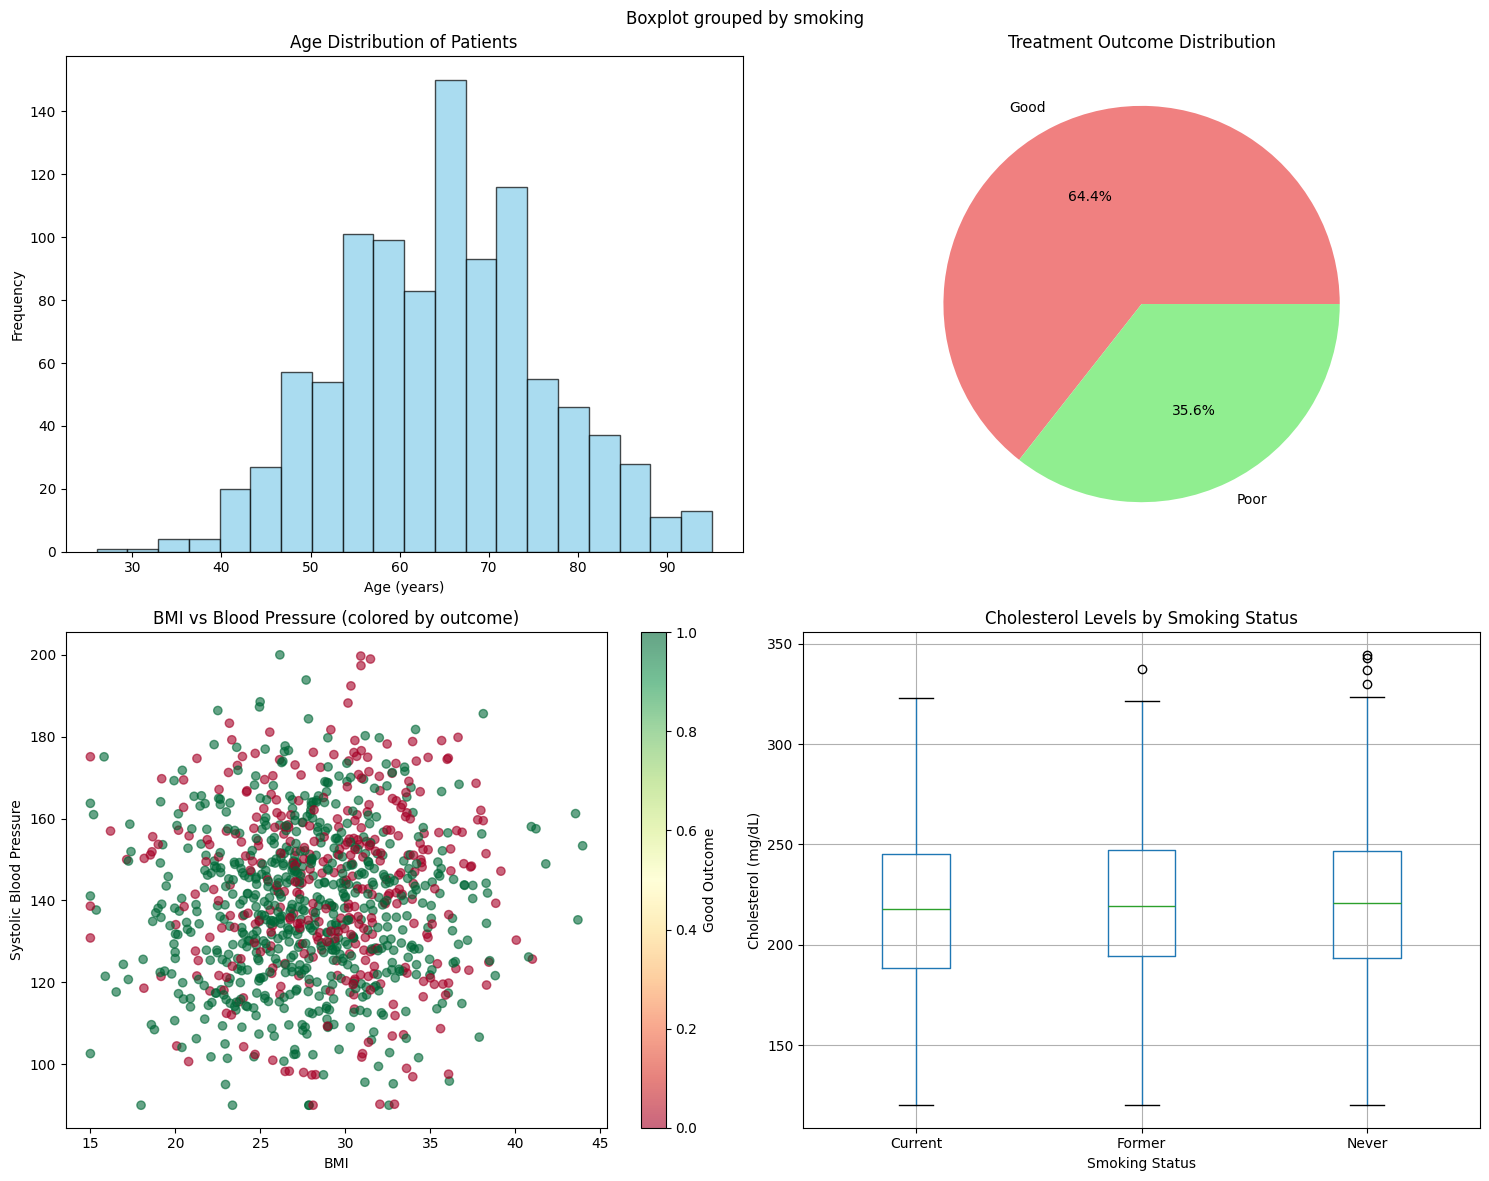

In [21]:
# Create subplots for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Age distribution
axes[0, 0].hist(df['age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution of Patients')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')

# 2. Treatment outcomes
outcome_counts = df['treatment_outcome'].value_counts()
axes[0, 1].pie(outcome_counts.values, labels=outcome_counts.index, autopct='%1.1f%%', 
               colors=['lightcoral', 'lightgreen'])
axes[0, 1].set_title('Treatment Outcome Distribution')

# 3. BMI vs Blood Pressure
scatter = axes[1, 0].scatter(df['bmi'], df['systolic_bp'], 
                           c=df['treatment_outcome'].map({'Good': 1, 'Poor': 0}),
                           cmap='RdYlGn', alpha=0.6)
axes[1, 0].set_xlabel('BMI')
axes[1, 0].set_ylabel('Systolic Blood Pressure')
axes[1, 0].set_title('BMI vs Blood Pressure (colored by outcome)')
plt.colorbar(scatter, ax=axes[1, 0], label='Good Outcome')

# 4. Cholesterol by smoking status
df.boxplot(column='cholesterol', by='smoking', ax=axes[1, 1])
axes[1, 1].set_title('Cholesterol Levels by Smoking Status')
axes[1, 1].set_xlabel('Smoking Status')
axes[1, 1].set_ylabel('Cholesterol (mg/dL)')

plt.tight_layout()
plt.show()

## 6. Preparing Data for Machine Learning

Before we can train our Random Forest model, we need to prepare the data:

In [22]:
# Prepare features for machine learning
# We need to convert categorical variables to numerical format

# Create a copy of the dataframe for preprocessing
df_ml = df.copy()

# Select features for the model
feature_columns = [
    'age', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'glucose',
    'exercise_hours_week'
]

X = df_ml[feature_columns]
y = df_ml['treatment_outcome']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget classes: {y.unique()}")


Feature matrix shape: (1000, 7)
Target vector shape: (1000,)

Target classes: ['Poor' 'Good']


## 7. Training a Random Forest Model

Random Forest is an excellent algorithm for medical prediction tasks because it:
- Handles mixed data types well
- Provides feature importance rankings
- Is relatively interpretable
- Performs well with limited data preprocessing

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} patients")
print(f"Testing set size: {X_test.shape[0]} patients")
print(f"\nTraining set outcome distribution:")
print(y_train.value_counts())

Training set size: 800 patients
Testing set size: 200 patients

Training set outcome distribution:
treatment_outcome
Good    515
Poor    285
Name: count, dtype: int64


In [24]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=10,           # Maximum depth of trees
    min_samples_split=5,    # Minimum samples required to split a node
    min_samples_leaf=2,     # Minimum samples required at a leaf node
    random_state=42         # For reproducibility
)

# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training completed!")

Training Random Forest model...
Model training completed!
